In [1]:
import numpy as np

import sys
sys.path.append('../..')
sys.path.append('../exp_5.1')

from tqdm.auto import trange

from matplotlib.pyplot import *

import pandas as pd

import pickle

from crisp import Distribution, GibbsPIS, LBPPIS
from exp51 import init_contacts

In [2]:
qEVec = [0.0000000000, 0.05908981283, 0.1656874653, 0.1819578343, 0.154807057,
         0.1198776096, 0.08938884645, 0.06572939883, 0.04819654533,
         0.03543733758, 0.02620080839, 0.01950646727, 0.01463254844,
         0.0110616426, 0.008426626119]

qIVec = [0.000000000000, 0.000000000000, 0.00000000000, 0.000000000000, 0.000000000000,
         0.0001178655952, 0.0006658439543, 0.002319264193, 0.005825713197, 0.01160465163,
         0.01949056696, 0.02877007836, 0.03842711373, 0.04743309657, 0.05496446107,
         0.06050719418, 0.06386313651, 0.065094874, 0.06444537162, 0.06225794729,
         0.0589104177, 0.05476817903, 0.05015542853, 0.0453410888, 0.04053528452,
         0.03589255717, 0.03151878504, 0.02747963753, 0.02380914891, 0.02051758911,
         0.01759822872, 0.01503287457, 0.0127962154, 0.01085910889, 0.009190974483,
         0.007761463001, 0.006541562648, 0.005504277076]

qE = Distribution([q/sum(qEVec) for q in qEVec])
qI = Distribution([q/sum(qIVec) for q in qIVec])

qIbar = np.sum(qIVec*np.arange(len(qIVec)))
print("qIbar={:.3f}".format(qIbar))

qIbar=19.862


In [86]:
update = True

T = 180
S = 1000

R0 = 1.0
alpha = 0.01 # PCR test false negative rate
beta = 0.0001 # PCR test false positive rate

p0 = 50e-5 /7 
p1 = 0.01

N_tests_per_day = 10
N_runs = 1000


exp_name = f'test_impact_S{S}_T{T}.pkl'

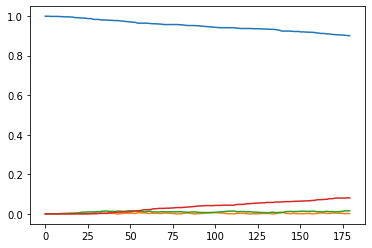

In [87]:
# create random contatcts fot 1000 people
contacts = init_contacts(S,T, qIbar, R0=R0, p1=p1)
contacts = np.concatenate(list(contacts.values()))

# build the ground truth CRISP model with patient_zero = True 
pis = GibbsPIS(S, T, contacts, [], qE, qI, alpha, beta, p0, p1, True)

# get a ground truth sample
Z = pis.sample(1)[0] 


plot((Z==0).mean(0))
plot((Z==1).mean(0))
plot((Z==2).mean(0))
plot((Z==3).mean(0))

In [90]:
Z

array([[1, 1, 2, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [92]:
tests

array([[  3,  20,   0],
       [790,  20,   0],
       [356,  20,   0],
       ...,
       [816, 177,   0],
       [212, 177,   0],
       [ 54, 177,   0]])

In [5]:
try:
    with open(exp_name,'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [83]:
for it in trange(N_runs):

    if not update:
        continue
        
    if it in results and results[it]['ok']:
        continue
    
    results[it] = {'ok': False}
        
    # create random contatcts fot 1000 people
    contacts = init_contacts(S,T, qIbar, R0=R0, p1=p1)
    contacts = np.concatenate(list(contacts.values()))

    # build the ground truth CRISP model with patient_zero = True 
    pis = GibbsPIS(S, T, contacts, [], qE, qI, alpha, beta, p0, p1, True)
    
    # get a ground truth sample
    Z = pis.sample(1)[0] 

    results[it]['Z'] = Z

    
    # build up random tests starting at day 20
    tests={}
    for t in range(20,T-2):
        i = np.random.choice(S, N_tests_per_day)

        # sample N_tests_per_day random test outcomes
        pos = np.random.binomial(size=N_tests_per_day, n=1, p=1.0-alpha)
        neg = np.random.binomial(size=N_tests_per_day, n=1, p=beta)
        
        # and build a list of tuples out of it 
        # and save it in a dictionary as tests for the day t
        tests[t] = list(zip(i,                                  # 1. the person id u
                            [t]*N_tests_per_day,                # 2. the date t
                            (Z[i,t]==2)*pos + (Z[i,t]!=2)*neg)) # 3. the test outcome

    # concatenate the dictionary into one list    
    # all test outcomes, positive and negative
    tests_all = np.concatenate(list(tests.values()))

    # filter    
    # only the tests with positive outcome
    tests_pos = np.array([t for t in tests_all if t[2]==1])

    # the number of positive test outcomes
    n_pt = len(tests_pos)
    results[it]['n_pos_tests'] = n_pt 

    # the fraction of positive test outcomes
    r_pt = len(tests_pos) / len(tests_all)
    results[it]['r_pos_tests'] = r_pt 
    
    print(f'{it}: n_pt={n_pt}({100*r_pt:.3f}%) ')
    
    # do inference over all test outcomes, positive test outcomes, and no tests
    for tests, descr in [(tests_all,'all'), 
                         (tests_pos,'pos'),
                         ([], 'no_tests')]: 
        
        # build a CRISP model with the true contacts, the tests, and patirnt_zero=False (becaus we don't know of her)
        pis_inference = LBPPIS(S, T, contacts, tests, qE, qI, alpha, beta, p0, p1, False)
        # pis_inference = GibbsPIS(S, T, contacts, tests, qE, qI, alpha, beta, p0, p1, False)
        
        # five sweeps of LBP, back and forth
        pis_inference.propagate(10,'baum_welch')
        
        # compute the estimated marginal distribution, shape==(S,T,4)
        p = pis_inference.get_marginals(10)[:,-1]
        # ... and a slice for the I state at the last day 
        p_infectious = p[:,2]
        
        # that's the 2 state (I or !I) likelihood of ground truth infection state Z
        l = np.log(p_infectious*(Z[:,-1]==2)+(1-p_infectious)*(Z[:,-1]!=2))
        
        l_split = np.array([np.log(p_infectious[Z[:,-1]==2]).sum(), np.log(1-p_infectious[Z[:,-1]!=2]).sum()]) 
        
        # save everything
        results[it]['tests_'+descr] = tests
        results[it]['p_'+descr] = p
        results[it]['l_'+descr] = l
        results[it]['l_split_'+descr] = l_split
        
        n_I = sum(Z[:,-1]==2)
        n_nI = sum(Z[:,-1]!=2)
        print(f'l_{descr:8s}={l.mean():.3f} ({l_split[0]/S:.3f},{l_split[1]/S:.3f}) ({l_split[0]/n_I:.3f},{l_split[1]/n_nI:.3f}) ')
    print()
    
    # close the record ...
    results[it]['ok'] = True
        
    # ... and savit to disk    
    with open(exp_name,'wb') as f:
        pickle.dump(results, f)
   


170: n_pt=7(0.443%) 
l_all     =-0.047 (-0.038,-0.009) (-4.741,-0.009) 
l_pos     =-0.050 (-0.032,-0.018) (-4.017,-0.018) 
l_no_tests=-0.047 (-0.035,-0.012) (-4.364,-0.012) 

171: n_pt=9(0.570%) 
l_all     =-0.067 (-0.057,-0.010) (-4.084,-0.010) 
l_pos     =-0.070 (-0.051,-0.019) (-3.653,-0.019) 
l_no_tests=-0.074 (-0.062,-0.012) (-4.415,-0.012) 

172: n_pt=22(1.392%) 
l_all     =-0.143 (-0.127,-0.016) (-3.848,-0.017) 
l_pos     =-0.141 (-0.113,-0.028) (-3.418,-0.029) 
l_no_tests=-0.156 (-0.144,-0.012) (-4.354,-0.012) 

173: n_pt=14(0.886%) 
l_all     =-0.061 (-0.051,-0.010) (-4.253,-0.010) 
l_pos     =-0.063 (-0.043,-0.020) (-3.606,-0.020) 
l_no_tests=-0.065 (-0.052,-0.012) (-4.363,-0.012) 

174: n_pt=4(0.253%) 
l_all     =-0.028 (-0.020,-0.007) (-5.061,-0.007) 
l_pos     =-0.032 (-0.017,-0.015) (-4.191,-0.015) 
l_no_tests=-0.030 (-0.018,-0.012) (-4.395,-0.012) 

175: n_pt=12(0.759%) 
l_all     =-0.058 (-0.049,-0.009) (-4.104,-0.009) 
l_pos     =-0.062 (-0.043,-0.019) (-3.581,-0.019) 

KeyboardInterrupt: 

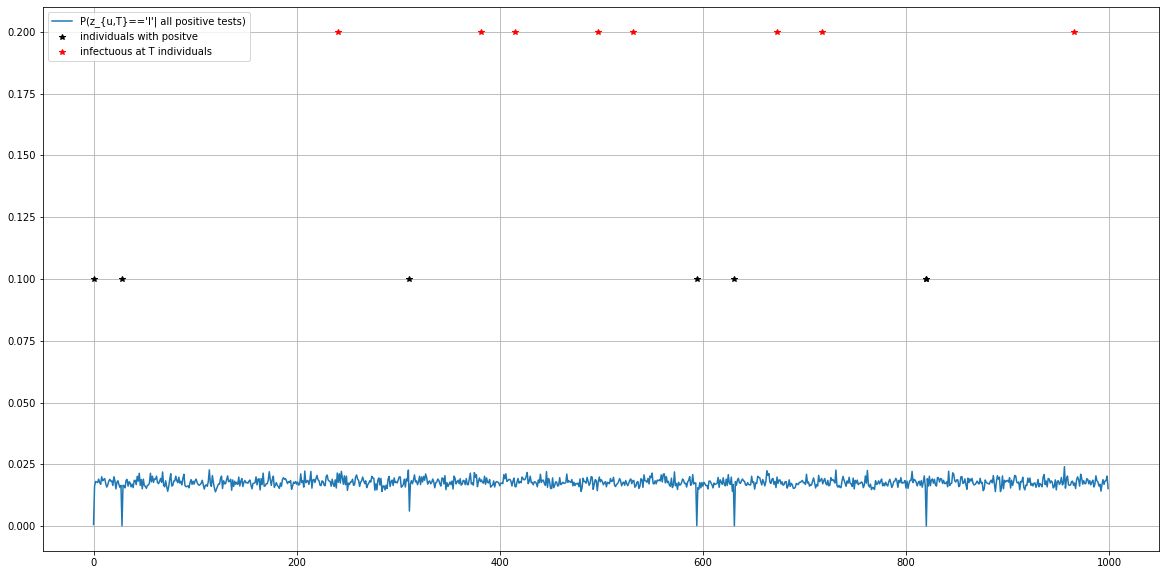

In [98]:
it = 170
figure(figsize=(20,10))
plot(results[it]['p_pos'][:,2])
plot(np.array(results[it]['tests_pos'])[:,0],0.1*np.ones_like(np.array(results[it]['tests_pos'])[:,0]),'k*')
plot(np.where(results[it]['Z'][:,-1]==2)[0], 0.2*np.ones_like(np.where(results[it]['Z'][:,-1]==2)[0]), 'r*')

grid(True)
legend(["P(z_{u,T}=='I'| all positive tests)",
       "individuals with positve",
        "infectuous at T individuals"
       ])